# Efficient epidemic state representation algorithm

## Load modules

In [81]:
using Pkg
Pkg.activate(".")
#Pkg.update()

  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/notebook`


In [94]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions, Random

# Static contact graph

In [83]:
NV = 100 # number of graph vertices
k = 3 # degree

# generate a random graph with NV vertices and NE edges
G = random_regular_graph(NV, k)

{100, 150} undirected simple Int64 graph

## - SI:

### System parameter definition and simulation

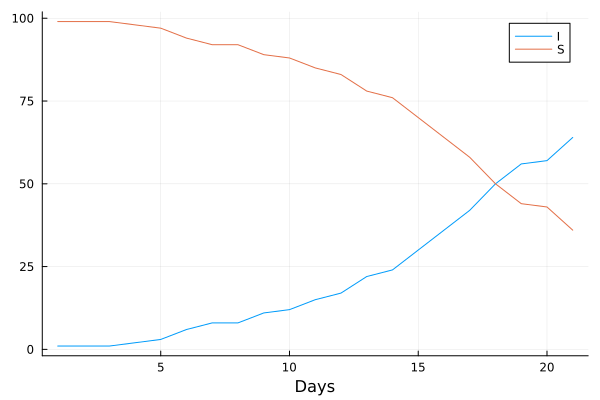

In [84]:
# define the constants
T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.2 # Infection rate
ε_autoinf = 1e-10 # Self-infection rate
Nobs = ceil(Int, NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob, x; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1
        return 1.0
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * Int8(-1)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

i = 1 ε = 0.9
i = 2 ε = 0.8956249243024632
i = 3 ε = 0.734945460022381
i = 4 ε = 0.5885321660142735
i = 5 ε = 0.5561546631850993
i = 6 ε = 0.43504166202052935
i = 7 ε = 0.38595755963726214
i = 8 ε = 0.2551151945827761
i = 9 ε = 0.18619392614773178
i = 10 ε = 0.09474433961870377
i = 11 ε = 0.048410884168799295
i = 12 ε = 0.027588007007597504
i = 13 ε = 0.011806253270561895
i = 14 ε = 0.010795696902987373
i = 15 ε = 0.010903582360763997
i = 16 ε = 0.007425925550607948
i = 17 ε = 0.0030589418969194093
i = 18 ε = 0.0011062711818117799
i = 19 ε = 0.0007240080781118485
i = 20 ε = 0.0004474431687889191
i = 21 ε = 0.0002745399933547499
i = 22 ε = 0.00032946601328720515
i = 23 ε = 0.00011485325711163563
i = 24 ε = 6.564894215443928e-5
i = 25 ε = 2.8311949233916778e-5
i = 26 ε = 2.679547453504627e-5
i = 27 ε = 3.373559984315433e-5
i = 28 ε = 1.1089974747913178e-5
i = 29 ε = 7.204345155997771e-6
i = 30 ε = 4.421847695279535e-6
i = 31 ε = 3.49046936237718e-6
i = 32 ε = 1.47277900541809e-6
i = 33 ε

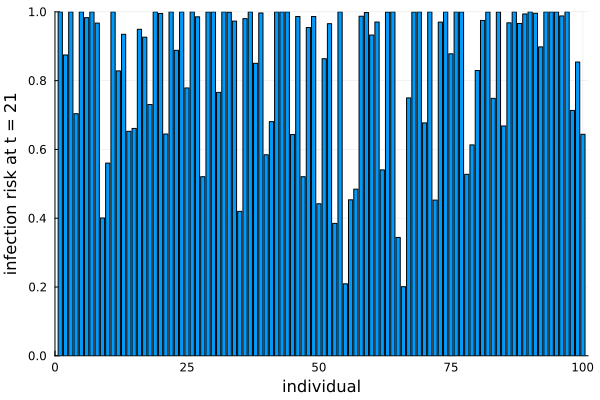

In [85]:
# computational constants
epsconv = 1e-10 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.1 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

risk = [node.marg.m[2,end] for node in nodes]
bar(risk, xlabel = "individual", ylabel = "infection risk at t = $(T+1)", label = "", ylim = (0,1), xlim=(0,NV+1))

## - SIS:

### System parameter definition and simulation

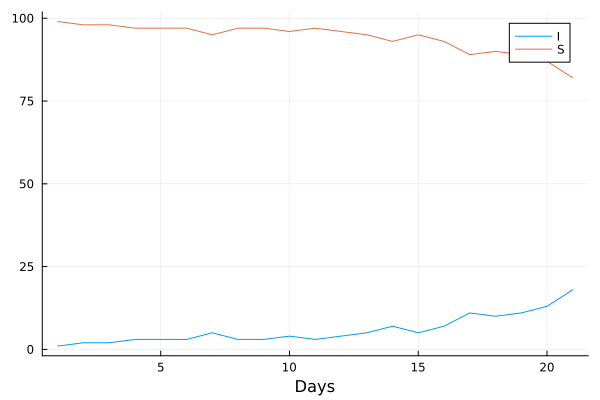

In [86]:
# define the constants
T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.2 # Infection rate
r₀ = 0.1 # Recovery rate
ε_autoinf4 = 1e-10 # Self-infection rate
Nobs = ceil(Int, NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob, x; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1
        return 1.0
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIS(ε_autoinf, r₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * Int8(-1)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

i = 1 ε = 0.9
i = 2 ε = 0.620983099797145
i = 3 ε = 0.5365383973104259
i = 4 ε = 0.5300324829428711
i = 5 ε = 0.41358867422844503
i = 6 ε = 0.4245660827331277
i = 7 ε = 0.3217861036679348
i = 8 ε = 0.2429053638425911
i = 9 ε = 0.23955279683914676
i = 10 ε = 0.2327523119865092
i = 11 ε = 0.15787906104993327
i = 12 ε = 0.12174842329935673
i = 13 ε = 0.07041197568275553
i = 14 ε = 0.07111275994959032
i = 15 ε = 0.04634025725379176
i = 16 ε = 0.03588614762449138
i = 17 ε = 0.038264879206738656
i = 18 ε = 0.019109000185133507
i = 19 ε = 0.009234201982035284
i = 20 ε = 0.007594403033850949
i = 21 ε = 0.004324509569524904
i = 22 ε = 0.003417194457620787
i = 23 ε = 0.0016793289441704995
i = 24 ε = 0.0011197783763022273
i = 25 ε = 0.0012152103099412614
i = 26 ε = 0.0004118829429947124
i = 27 ε = 0.00039359246917619606
i = 28 ε = 0.00028414060780623807
i = 29 ε = 0.00017866099281430015
i = 30 ε = 9.679552617070097e-5
i = 31 ε = 7.653491962467118e-5
i = 32 ε = 4.6969792619616646e-5
i = 33 ε = 4.7

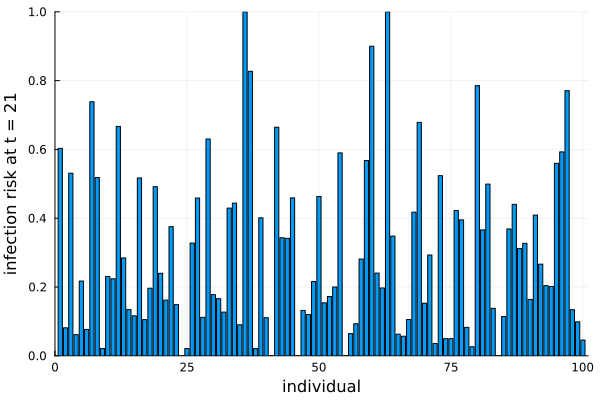

In [87]:
# computational constants
epsconv = 1e-10 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.1 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

risk = [node.marg.m[2,end] for node in nodes]
bar(risk, xlabel = "individual", ylabel = "infection risk at t = $(T+1)", label = "", ylim = (0,1), xlim=(0,NV+1))

## - SIR:

### System parameter definition and simulation

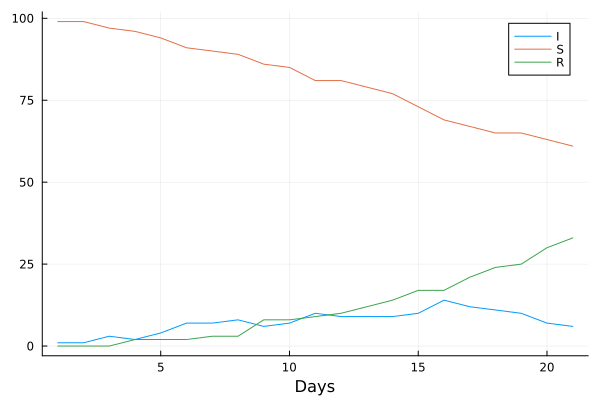

In [88]:
# define the constants
T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.3 # Infection rate
r₀ = 0.2 # Recovery rate
ε_autoinf = 1e-10 # Self-infection rate
Nobs = ceil(Int, NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIR(ε_autoinf, r₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * Int8(-1)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])


### Inference

i = 1 ε = 0.9
i = 2 ε = 0.8633688199801722
i = 3 ε = 0.7707983857550121
i = 4 ε = 0.46036122558638004
i = 5 ε = 0.4197079422617447
i = 6 ε = 0.301132547132353
i = 7 ε = 0.13785796439837483
i = 8 ε = 0.14453459889898235
i = 9 ε = 0.08905604277266455
i = 10 ε = 0.03957915440497095
i = 11 ε = 0.017492028281799243
i = 12 ε = 0.018978245313697517
i = 13 ε = 0.007321963203899884
i = 14 ε = 0.005438116091648515
i = 15 ε = 0.003136086045065989
i = 16 ε = 0.00151539617876717
i = 17 ε = 0.0020243852736812062
i = 18 ε = 0.000681032619571309
i = 19 ε = 0.0006011045743207211
i = 20 ε = 0.0004649226925900751
i = 21 ε = 0.00020478955614200434
i = 22 ε = 0.000338377922163402
i = 23 ε = 0.0001776040969208581
i = 24 ε = 9.080603402483733e-5
i = 25 ε = 5.9606366783260256e-5
i = 26 ε = 5.2497100356097004e-5
i = 27 ε = 1.6251751536244807e-5
i = 28 ε = 2.2166388460864717e-5
i = 29 ε = 4.856844348699596e-6
i = 30 ε = 7.599082014364544e-6
i = 31 ε = 3.1867594421641776e-6
i = 32 ε = 2.279529804027902e-6
i = 33

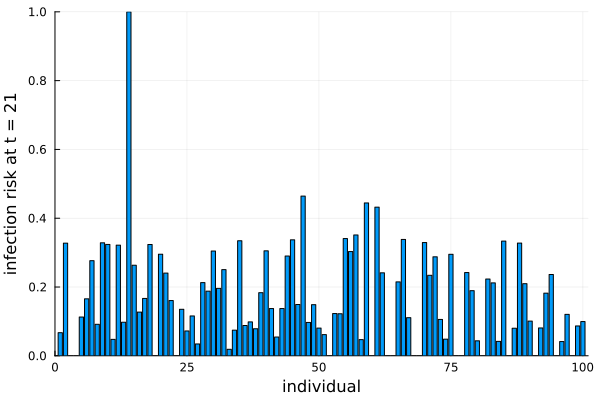

In [89]:
# computational constants
epsconv= 1e-10 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.1 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

risk = [node.marg.m[2,end] for node in nodes]
bar(risk, xlabel = "individual", ylabel = "infection risk at t = $(T+1)", label = "", ylim = (0,1), xlim=(0,NV+1))

## - SIRS:

### System parameter definition and simulation

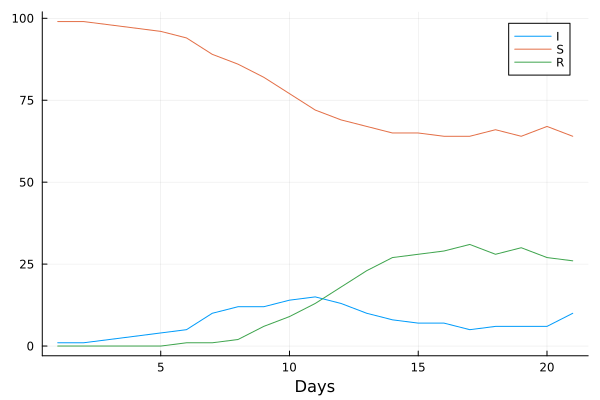

In [90]:
# define the constants
T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.3 # Infection rate
r₀ = 0.2 # Recovery rate
σ₀ = 0.02 # Immunity rate
ε_autoinf = 1e-10 # Self-infection rate
Nobs = ceil(Int, NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * Int8(-1)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])

### Inference

i = 1 ε = 0.9
i = 2 ε = 0.6234169117313549
i = 3 ε = 0.4992463010557506
i = 4 ε = 0.45141012700652766
i = 5 ε = 0.38486134705868585
i = 6 ε = 0.38643605829675287
i = 7 ε = 0.26221405498673367
i = 8 ε = 0.33883491398759785
i = 9 ε = 0.1425051416430764
i = 10 ε = 0.06042839743613382
i = 11 ε = 0.05311381497177557
i = 12 ε = 0.03538460576987611
i = 13 ε = 0.049795611028254
i = 14 ε = 0.009600395054019106
i = 15 ε = 0.0073511775655438205
i = 16 ε = 0.0018566896898023488
i = 17 ε = 0.003802767834731935
i = 18 ε = 0.0021367044944178015
i = 19 ε = 0.0006490873512947637
i = 20 ε = 0.00035785561697154744
i = 21 ε = 0.0005323780807842682
i = 22 ε = 0.00023006944355036252
i = 23 ε = 0.00012835254872817226
i = 24 ε = 4.654082886840216e-5
i = 25 ε = 1.673876161623067e-5
i = 26 ε = 1.0772600836150836e-5
i = 27 ε = 7.113093508759327e-6
i = 28 ε = 2.730652818083712e-6
i = 29 ε = 2.093374422335037e-6
i = 30 ε = 1.8052023904591152e-6
i = 31 ε = 5.672393255107266e-7
i = 32 ε = 3.58456996862877e-7
i = 33 

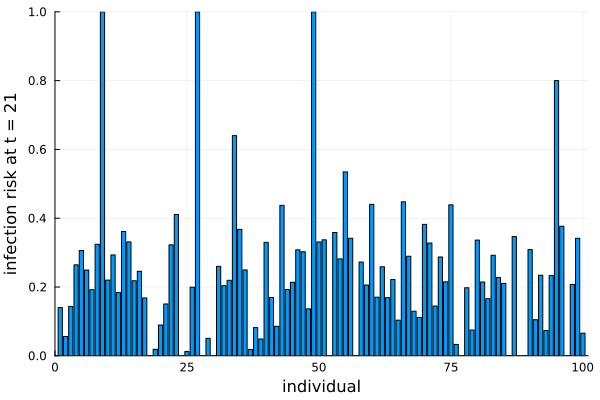

In [91]:
# computational constants
epsconv = 1e-10 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.1 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

risk = [node.marg.m[2,end] for node in nodes]
bar(risk, xlabel = "individual", ylabel = "infection risk at t = $(T+1)", label = "", ylim = (0,1), xlim=(0,NV+1))

# Time-varying contact graph - SI model

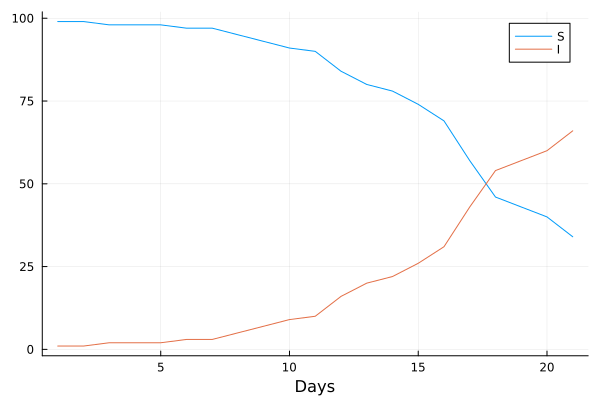

In [92]:
NV = 100 # number of graph vertices
K = 3 # degree

T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.2 # Infection rate
ε_autoinf = 1e-10 # Self-infection rate
Nobs = ceil(Int, NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob, x; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1
        return 1.0
    end
end

G = Vector{SimpleGraph{Int64}}()
λ = zeros(NV, NV, T+1)

for t in 1:T+1
    g = erdos_renyi(NV, K/NV)
    push!(G,g)
    for e in edges(g)
        λ[src(e), dst(e), t] = rand() * λ₀
        λ[dst(e), src(e), t] = rand() * λ₀
    end
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(NV, T+1) * Int8(-1)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrS nrI], xlabel = "Days", ylabel = "", label = ["S" "I"])

i = 1 ε = 0.9
i = 2 ε = 0.7627181038950597
i = 3 ε = 0.5474840754178311
i = 4 ε = 0.37914676348228776
i = 5 ε = 0.4907925028135999
i = 6 ε = 0.3741761364394819
i = 7 ε = 0.1807174722753237
i = 8 ε = 0.048311342384068756
i = 9 ε = 0.035786801987521655
i = 10 ε = 0.01024173184549515
i = 11 ε = 0.00381906043530858
i = 12 ε = 0.0012645232120882532
i = 13 ε = 0.0004602431718717659
i = 14 ε = 0.00018647833559970461
i = 15 ε = 9.809499064422633e-5
i = 16 ε = 3.664549452736532e-5
i = 17 ε = 1.6483203277462e-5
i = 18 ε = 4.268531662299235e-6
Converged after 18 iterations


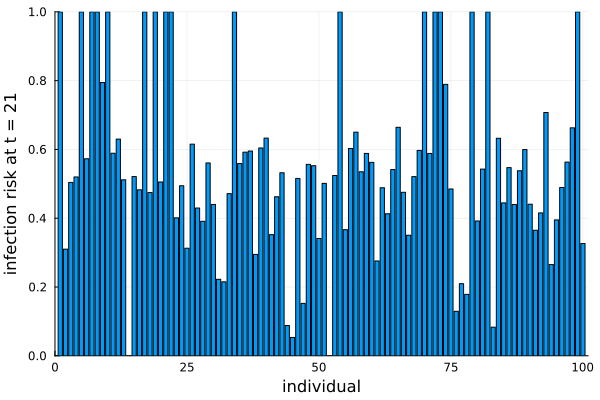

In [93]:
# computational constants
epsconv = 1e-5 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.1 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

risk = [node.marg.m[2,end] for node in nodes]
bar(risk, xlabel = "individual", ylabel = "infection risk at t = $(T+1)", label = "", ylim = (0,1), xlim=(0,NV+1))